In [1]:
%matplotlib inline
from pylab import *
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
from dataset import load_image

In [4]:
import torch

In [5]:
from utils import cuda

In [6]:
from generate_masks import get_model

In [7]:
from albumentations import Compose, Normalize

In [8]:
from albumentations.pytorch.functional import img_to_tensor

In [9]:
def img_transform(p=1):
    return Compose([
        Normalize(p=1)
    ], p=p)


In [10]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [11]:
#model_path = 'runs/debug/model_0.pt'
#model_path = 'runs/debug/model_0_lovasz.pt'
#model = get_model(model_path, model_type='TernausNetOC', problem_type='parts')

model_path = 'runs/ternaus_instruments_jul10/model_0.pt'
model = get_model(model_path, model_type='TernausNetV2', problem_type='instruments')


In [12]:
img_file_name = 'data/cropped_train/instrument_dataset_3/images/frame004.jpg'
#img2 = 'data/cropped_train/instrument_dataset_3/images/frame083.jpg'
#img_file_name = 'data/testing/instrument_dataset_3/right_frames/frame295.png'
#gt_file_name = 'data/cropped_train/instrument_dataset_3/binary_masks/frame004.png'

In [13]:
#image = load_image(img_file_name)
#gt = cv2.imread(gt_file_name, 0) > 0
image = load_image(img_file_name)

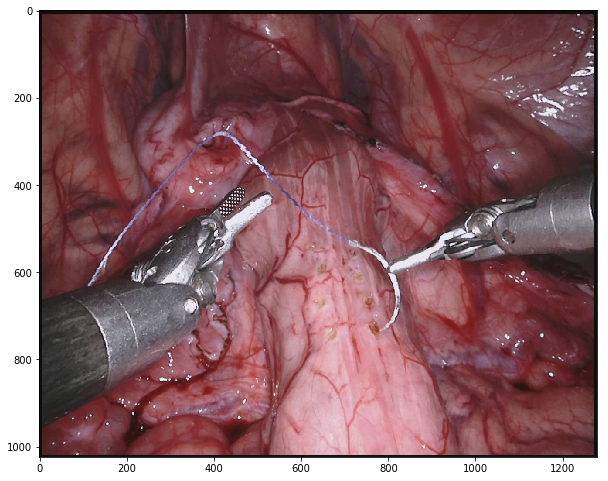

In [14]:
#imshow(image)
imshow(image)

In [15]:
#CUDA_VISIBLE_DEVICES=1,2
with torch.no_grad():
    input_image = torch.unsqueeze(img_to_tensor(img_transform(p=1)(image=image)['image']).cuda(), dim=0)

In [16]:
mask = model(input_image)

In [17]:
mask_array = mask.data[0].cpu().numpy()[0]

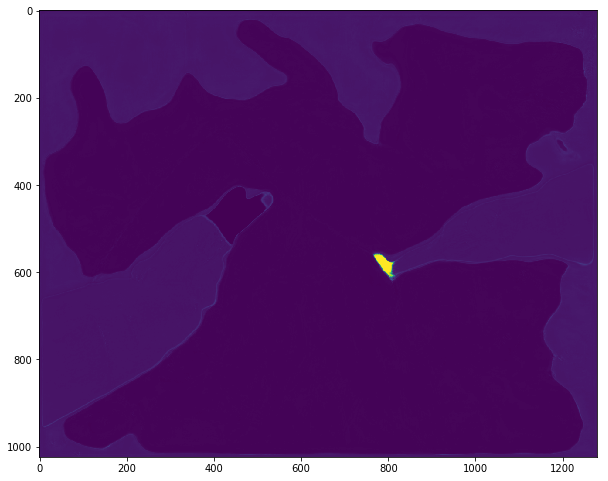

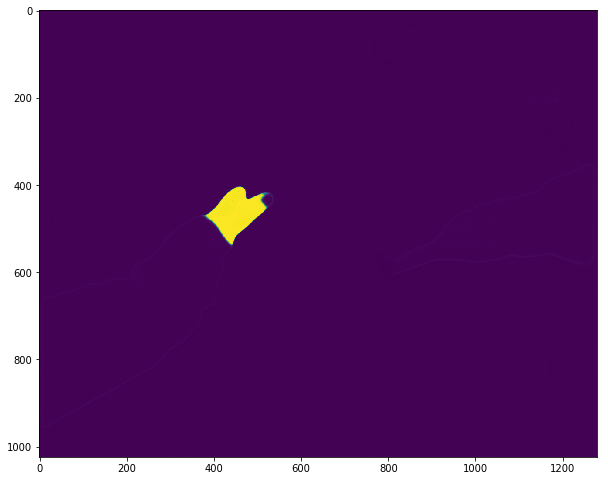

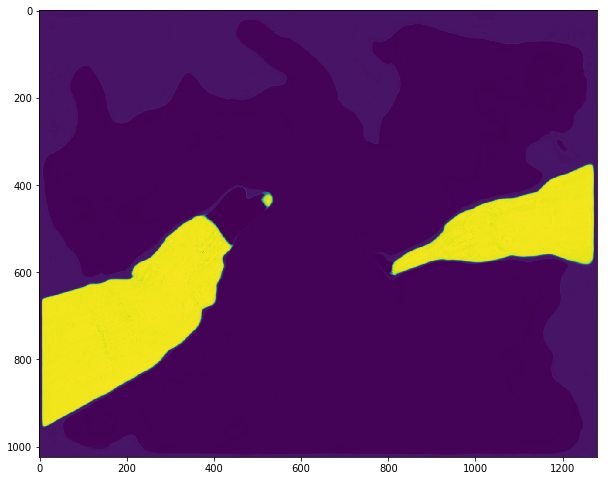

In [18]:
#imshow(mask_array > 0)
plt.figure()
plt.imshow(torch.exp(mask.data[0,1,:]).detach().cpu())  # plot class1
plt.figure()
plt.imshow(torch.exp(mask.data[0,2,:,:]).detach().cpu())  # plot class2
plt.figure()
plt.imshow(torch.exp(mask.data[0,3,:,:]).detach().cpu())  # plot class3

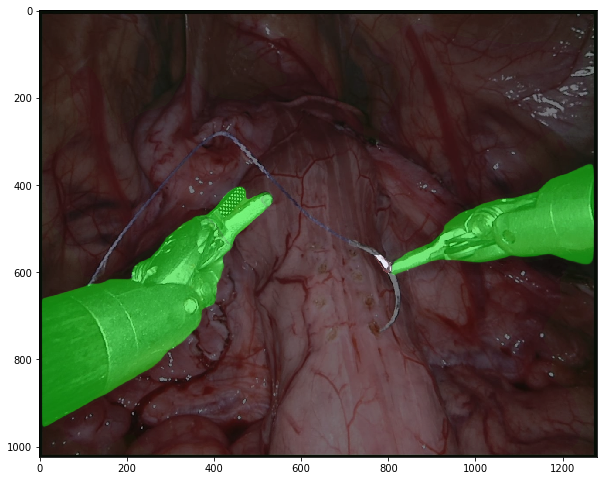

In [19]:
#imshow(mask_overlay(image, (torch.exp(mask.data[0,3,:]).detach().cpu()))) #parts
# plt.imshow(torch.exp(mask.data[0,1,:]).detach().cpu())  # plot class1
# plt.figure()
# plt.imshow(torch.exp(mask.data[0,2,:,:]).detach().cpu())  # plot class2
# plt.figure()
# plt.imshow(torch.exp(mask.data[0,3,:,:]).detach().cpu()) 
combined =  torch.exp(mask.data[0,2,:,:]).detach().cpu() + torch.exp(mask.data[0,3,:,:]).detach().cpu()
#imshow(combined)
imshow(mask_overlay(image, combined))#imshow(mask_overlay(image, (mask_array > 0).astype(np.uint8)))